In [1]:
'''
This code takes FLASK output (convergence, shear, density fields) and add DES Y3 shape noise. It create maps of the shear field that needs to be used to compute the moments convariance.
'''
import gc
# import pyfits as pf
import pickle
import numpy as np

import healpy as hp
import os
import copy
# from Moments_analysis import convert_to_pix_coord, IndexToDeclRa, apply_random_rotation, addSourceEllipticity, gk_inv
import healpy as hp
import scipy
from scipy.interpolate import interp1d
import timeit
import glob
import UFalcon
import ekit
from ekit import paths as path_tools
# import frogress
from tqdm import tqdm



import numpy as np
import scipy.integrate as integrate
from scipy.interpolate import interp1d

from UFalcon import utils
from UFalcon import constants as constants_u






In [2]:
class Continuous:
    """
    Computes the lensing weights for a continuous, user-defined n(z) distribution.
    """

    def __init__(self, n_of_z, z_lim_low=0, z_lim_up=None, shift_nz=0.0, IA=0.0):
        """
        Constructor.
        :param n_of_z: either path to file containing n(z), assumed to be a text file readable with numpy.genfromtext
                        with the first column containing z and the second column containing n(z), or a callable that
                        is directly a redshift distribution
        :param z_lim_low: lower integration limit to use for n(z) normalization, default: 0
        :param z_lim_up: upper integration limit to use for n(z) normalization, default: last z-coordinate in n(z) file
        :param shift_nz: Can shift the n(z) function by some redshift (intended for easier implementation of photo z bias)
        :param IA: Intrinsic Alignment. If not None computes the lensing weights for IA component
                        (needs to be added to the weights without IA afterwards)
        """

        # we handle the redshift dist depending on its type
        if callable(n_of_z):
            if z_lim_up is None:
                raise ValueError("An upper bound of the redshift normalization has to be defined if n_of_z is not a "
                                 "tabulated function.")

            self.nz_intpt = n_of_z
            # set the integration limit and integration points
            self.lightcone_points = None
            self.limit = 1000
        else:
            # read from file
            nz = np.genfromtxt(n_of_z)

            # get the upper bound if necessary
            if z_lim_up is None:
                z_lim_up = nz[-1, 0]

            # get the callable function
            self.nz_intpt = interp1d(nz[:, 0] - shift_nz, nz[:, 1], bounds_error=False, fill_value=0.0)

            # points for integration
            self.lightcone_points = nz[np.logical_and(z_lim_low < nz[:, 0], nz[:, 0] < z_lim_up), 0]

            # check if there are any points remaining for the integration
            if len(self.lightcone_points) == 0:
                self.lightcone_points = None
                self.limit = 1000
            else:
                self.limit = 10 * len(self.lightcone_points)

        self.z_lim_up = z_lim_up
        self.z_lim_low = z_lim_low
        self.IA = IA
        # Normalization
        self.nz_norm = integrate.quad(lambda x: self.nz_intpt(x), z_lim_low, self.z_lim_up,
                                      points=self.lightcone_points, limit=self.limit)[0]

    def __call__(self, z_low, z_up, cosmo, lens = False):
        """
        Computes the lensing weights for the redshift interval [z_low, z_up].
        :param z_low: lower end of the redshift interval
        :param z_up: upper end of the redshift interval
        :param cosmo: Astropy.Cosmo instance, controls the cosmology used
        :return: lensing weight
        """
        if lens:
            norm = (z_up - z_low) * self.nz_norm
            # lensing weights
            def f(x):
                return (self.nz_intpt(x))

            if self.lightcone_points is not None:
                numerator = integrate.quad(f, z_low, z_up, points=self.lightcone_points[np.logical_and(z_low < self.lightcone_points, self.lightcone_points < z_up)])[0]
            else:
                numerator = integrate.quad(f, z_low, z_up)[0]
            return numerator / norm
        else:
            norm = utils.dimensionless_comoving_distance(z_low, z_up, cosmo) * self.nz_norm
            norm *= (utils.dimensionless_comoving_distance(0., (z_low + z_up)/2., cosmo) ** 2.)
            if abs(self.IA - 0.0) < 1e-10:
                # lensing weights without IA
                numerator = integrate.quad(self._integrand_1d, z_low, z_up, args=(cosmo,))[0]
            else:
                # lensing weights for IA
                numerator = (2.0/(3.0*cosmo.Om0)) * \
                            w_IA(self.IA, z_low, z_up, cosmo, self.nz_intpt, points=self.lightcone_points)

            return numerator / norm

    def _integrand_2d(self, y, x, cosmo):
        """
        The 2d integrant of the continous lensing weights
        :param y: redhsift that goes into the n(z)
        :param x: redshift for the Dirac part
        :param cosmo: Astropy.Cosmo instance, controls the cosmology used
        :return: the 2d integrand function
        """
        return self.nz_intpt(y) * \
               utils.dimensionless_comoving_distance(0, x, cosmo) * \
               utils.dimensionless_comoving_distance(x, y, cosmo) * \
               (1 + x) * \
               cosmo.inv_efunc(x) / \
               utils.dimensionless_comoving_distance(0, y, cosmo)

    def _integrand_1d(self, x, cosmo):
        """
        Function that integrates out y from the 2d integrand
        :param x: at which x (redshfit to eval)
        :param cosmo: Astropy.Cosmo instance, controls the cosmology used
        :return: the 1d integrant at x
        """
        if self.lightcone_points is not None:
            points = self.lightcone_points[np.logical_and(self.z_lim_low < self.lightcone_points,
                                                          self.lightcone_points < self.z_lim_up)]
            quad_y = lambda x: integrate.quad(lambda y: self._integrand_2d(y, x, cosmo), x, self.z_lim_up,
                                              limit=self.limit, points=points)[0]
        else:
            quad_y = lambda x: integrate.quad(lambda y: self._integrand_2d(y, x, cosmo), x, self.z_lim_up,
                                              limit=self.limit)[0]

        return quad_y(x)

def w_IA(IA, z_low, z_up, cosmo, nz_intpt, points=None):
    """
    Calculates the weight per slice for the NIA model given a
    distribution of source redshifts n(z).
    :param IA: Galaxy Intrinsic alignment amplitude
    :param z_low: Lower redshift limit of the shell
    :param z_up: Upper redshift limit of the shell
    :param cosmo: Astropy.Cosmo instance, controls the cosmology used
    :param nz_intpt: nz function
    :param points: Points in redshift where integrand is evaluated (used for better numerical integration), can be None
    :return: Shell weight for NIA model

    """

    def f(x):
        return (F_NIA_model(x, IA, cosmo) * nz_intpt(x))

    if points is not None:
        dbl = integrate.quad(f, z_low, z_up, points=points[np.logical_and(z_low < points, points < z_up)])[0]
    else:
        dbl = integrate.quad(f, z_low, z_up)[0]

    return dbl


def density_prefactor(n_pix, n_particles, boxsize, cosmo):
    """
    Computes the prefactor to transform from number of particles to convergence, see https://arxiv.org/abs/0807.3651,
    eq. (A.1).
    :param n_pix: number of healpix pixels used
    :param n_particles: number of particles
    :param boxsize: size of the box in Gigaparsec
    :param cosmo: Astropy.Cosmo instance, controls the cosmology used
    :return: convergence prefactor
    """
    convergence_factor = (n_pix / (4.0 * np.pi)) * \
                         (cosmo.H0.value / constants_u.c) ** 2 * \
                         (boxsize * 1000.0) ** 3 / n_particles
    return convergence_factor


def get_parameters_from_path(paths, suffix=True, fmt=None):
    """
    Given a list of standardised paths, or a single path created with
    create_path() this function reads the parameters in the paths.

    :param paths: Either a single string or a list of strings. The strings
                  should be paths in the create_path() format.
    :param suffix: If True assumes that the given paths have suffixes and
                   exclues them from the parsing
    :return: Returns a dictionary which contains the defined parameters and
             a list containing the undefined parameters.
    """
    # convert to list if needed
    if not isinstance(paths, list):
        paths = [paths]

    # use first path to initialize the dictionary and list for output
    defined_names = []
    undefined_count = 0
    path = paths[0]

    path = _prepare_path(path, suffix=suffix)

    # loop over parameters in first path to initialize dictionary
    for c in path:
        if isinstance(c, list):
            c = c[0]
        if '=' in c:
            b = c.split('=')
            defined_names.append(b[0])
        else:
            undefined_count += 1

    # initialize
    undefined = np.zeros((len(paths), undefined_count), dtype=object)
    defined = {}
    for d in defined_names:
        defined[d] = np.zeros(len(paths), dtype=object)

    # loop over files and get parameters
    for ii, path in enumerate(paths):
        path = _prepare_path(path, suffix=suffix)
        count = 0
        for idx_c, c in enumerate(path):
            if isinstance(c, list):
                c = c[0]
            if '=' in c:
                b = c.split('=')
                to_add = _check_type(b[1], fmt, idx_c)
                defined[b[0]][ii] = to_add
            else:
                to_add = _check_type(c, fmt, idx_c)
                undefined[ii, count] = to_add
                count += 1
    return defined, undefined






In [13]:
import yaml
def make_maps(jz, jr, ns=512):
    import healpy as hp
    from tqdm import tqdm
    ldir = '/global/cfs/cdirs/des/cosmogrid/raw/fiducial/cosmo_fiducial/run_' + str(jr) + '/'
    with open(ldir + 'params.yml') as f:
        data = yaml.load(f, Loader=yaml.FullLoader)
    Omegam, sig8 = data['Om'], data['s8']
    h = data['H0']/100.

    
    df = np.load(ldir + 'compressed_shells.npz')
    nsh = len(df['shell_info'])
    shid, sh_lz, sh_hz = np.zeros(nsh), np.zeros(nsh), np.zeros(nsh)
    for js in range(len(df['shell_info'])):
        shid[js], sh_lz[js], sh_hz[js] = df['shell_info'][js][1], df['shell_info'][js][2], df['shell_info'][js][3]
    z_bounds = {'z-low': sh_lz, 'z-high': sh_hz}
    # defines cosmology for PKDGRAV sims
    from astropy.cosmology import FlatLambdaCDM
    constants = FlatLambdaCDM(H0=float(h * 100.), Om0=float(Omegam))
    

    kappa = np.zeros((1, hp.nside2npix(2048)), dtype=np.float32)      
    ldir = '/global/cfs/cdirs/des/shivamp/cosmosis2p0/cosmosis-standard-library/gen_moments/'      
    path_nz = ldir + 'nz_source_bin' + str(jz+1) + '.txt'
    lensing_weights = UFalcon.lensing_weights.Continuous(
            path_nz, z_lim_low=0., z_lim_up=4., shift_nz=0., IA=0.)
    
    shell_files = df['shells']
    for zz in tqdm(range(len(z_bounds['z-low']))):
        shell = shell_files[zz].astype(np.float64)
        # conversion from particle counts to convergence
        kappa_prefactor = UFalcon.lensing_weights.kappa_prefactor(
                        n_pix=shell.size, n_particles=832**3,
                        boxsize=1.33610451306, cosmo=constants)
        shell *= kappa_prefactor

        # Add the shell multiplied by the lensing weights
        weight = lensing_weights(
            z_bounds['z-low'][zz], z_bounds['z-high'][zz], constants)
        shell *= weight

        kappa += shell

    sdir = '/global/cfs/cdirs/lsst/www/shivamp/gen_mom/cosmogrid_kappa/fiducial/ns_2048/'
    hp.write_map(sdir + 'kappa-jr-' + str(jr) + '-jz-' + str(jz) + '.fits', kappa)
    kappa_dg = hp.ud_grade(kappa, 512)
    sdir = '/global/cfs/cdirs/lsst/www/shivamp/gen_mom/cosmogrid_kappa/fiducial/ns_512/'
    hp.write_map(sdir + 'kappa-jr-' + str(jr) + '-jz-' + str(jz) + '.fits', kappa_dg)
    # return kappa
    
# def save_kappa_batch(jrank, njobs):
#     ni = 0
#     nf = 57
#     lhs_all = np.arange(ni,nf)
#     lhs_all_split = np.split(lhs_all,njobs)
#     lhs_jrank = lhs_all_split[jrank]
#     for lhs in (lhs_jrank):
#         make_maps(lhs, 0)
#         make_maps(lhs, 1)
#         make_maps(lhs, 2)
#         make_maps(lhs, 3)
#         make_maps(lhs, 4)

# # make_maps(0, 0)      

# from mpi4py import MPI
# if __name__ == '__main__':
#     run_count = 0
#     n_jobs = 57
#     # jr = 0

#     while run_count<n_jobs:
#         comm = MPI.COMM_WORLD
#         print("Hello! I'm rank %d from %d running in total..." % (comm.rank, comm.size))
#         if (run_count+comm.rank) < n_jobs:
#             save_kappa_batch(comm.rank, n_jobs)
#         run_count+=comm.size
#         comm.bcast(run_count,root = 0)
#         comm.Barrier()     

# # from mpi4py import MPI 
# # if __name__ == '__main__':
# #     runstodo=[]
# #     for i in range(0,1):
# #         #if not os.path.exists(output+'seedomb_'+str(i+1)+'.pkl'):
# #             runstodo.append(i)
# #     run_count=0
# #     print (runstodo)
# #     while run_count<len(runstodo):
# #         comm = MPI.COMM_WORLD
# #         print("Hello! I'm rank %d from %d running in total..." % (comm.rank, comm.size))
# #         try:
# #             make_maps(runstodo[run_count+comm.rank])
# #         except:
# #             pass
# #         run_count+=comm.size
# #         comm.bcast(run_count,root = 0)
# #         comm.Barrier() 
        
# # salloc -N 57 -C haswell -q interactive -t 02:00:00 -L SCRATCH
# # srun --nodes=57 --tasks-per-node=1 --cpu-bind=cores python make_kappamap_pkdgrav.py

In [14]:
jz = 3
jr = 0
kappa_here = make_maps(jz, jr)


100%|██████████| 69/69 [09:09<00:00,  7.96s/it]


In [15]:
# jz = 3
# jr = 0
# kappa_repo = ldir = '/global/cfs/cdirs/des/cosmogrid/raw/fiducial/cosmo_fiducial/run_' + str(jr) + '/'



In [16]:
import h5py as h5
jz = 3
jr = 0
df_sim = h5.File('/global/cfs/cdirs/des/cosmogrid/DESY3/fiducial/cosmo_fiducial/perm_0000/projected_probes_maps_nobaryons512.h5','r')
kappa_dfi = df_sim['kg']['desy3metacal' + str(jz+1)][:]




In [17]:
kappa_here_ns512 = hp.ud_grade(kappa_here, 512)


In [19]:
kappa_dfi.shape, kappa_here_ns512.shape


((3145728,), (1, 3145728))

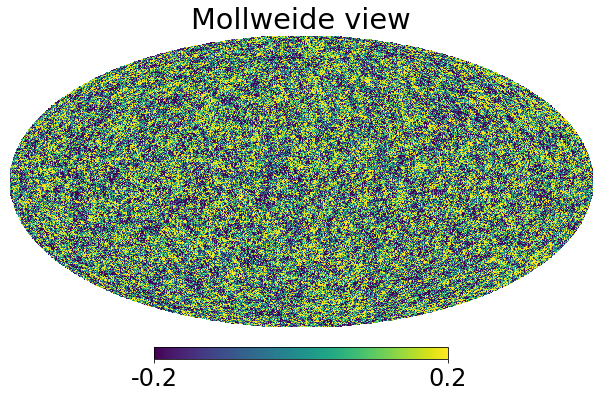

In [28]:
pl.rcParams['text.usetex'] = False
hp.mollview((kappa_here_ns512[0,:] - kappa_dfi)/kappa_here_ns512[0,:], min=-0.2, max=0.2)



In [24]:
import h5py as h5
def ang2eq(theta, phi):
    ra = phi * 180. / np.pi
    dec = 90. - theta * 180. / np.pi
    return ra, dec


def eq2ang(ra, dec):
    phi = ra * np.pi / 180.
    theta = (np.pi / 2.) - dec * (np.pi / 180.)
    return theta, phi

def get_zmean(zcent,delz,nz_bin):
    prob_zcent = nz_bin
    zmean = (np.sum(prob_zcent*zcent*delz))/(np.sum(prob_zcent*delz))
    return zmean



In [25]:
import treecorr
from tqdm import tqdm
ldir = '/global/cfs/cdirs/des/mgatti/maps_shivam/'
nsim =50
minrad = 6.0
maxrad = 250.0
nrad = 15
dfj0 = kappa_here_ns512[0,:]
npix_ymap = len(dfj0)
nside_ymap = hp.npix2nside(npix_ymap)
pix_theta, pix_phi = hp.pix2ang(nside_ymap, np.arange(npix_ymap))
pix_ra, pix_dec = ang2eq(pix_theta, pix_phi)
pix_ra_k, pix_dec_k = pix_ra, pix_dec
# xi_kappa_orig = np.zeros((nrad, nsim))
# for ji in tqdm(range(nsim)):
kappa_cat = treecorr.Catalog(ra=pix_ra_k, dec=pix_dec_k, k=dfj0-np.mean(dfj0),
                                        ra_units='degrees', dec_units='degrees')
            
# print('doing kw calculation')
kappaw = treecorr.KKCorrelation(nbins=nrad, min_sep=minrad, max_sep=maxrad, sep_units='arcmin', verbose=0,bin_slop=0.0) 
kappaw.process(kappa_cat, kappa_cat)
xi_kappaw_here = kappaw.xi
r_kappaw_here = np.exp(kappaw.meanlogr)







In [26]:
import treecorr
from tqdm import tqdm
ldir = '/global/cfs/cdirs/des/mgatti/maps_shivam/'
nsim =50
minrad = 6.0
maxrad = 250.0
nrad = 15
dfj0 = kappa_dfi
npix_ymap = len(dfj0)
nside_ymap = hp.npix2nside(npix_ymap)
pix_theta, pix_phi = hp.pix2ang(nside_ymap, np.arange(npix_ymap))
pix_ra, pix_dec = ang2eq(pix_theta, pix_phi)
pix_ra_k, pix_dec_k = pix_ra, pix_dec
# xi_kappa_orig = np.zeros((nrad, nsim))
# for ji in tqdm(range(nsim)):
kappa_cat = treecorr.Catalog(ra=pix_ra_k, dec=pix_dec_k, k=dfj0-np.mean(dfj0),
                                        ra_units='degrees', dec_units='degrees')
            
# print('doing kw calculation')
kappaw = treecorr.KKCorrelation(nbins=nrad, min_sep=minrad, max_sep=maxrad, sep_units='arcmin', verbose=0,bin_slop=0.0) 
kappaw.process(kappa_cat, kappa_cat)
xi_kappaw_dfi = kappaw.xi
r_kappaw_dfi = np.exp(kappaw.meanlogr)







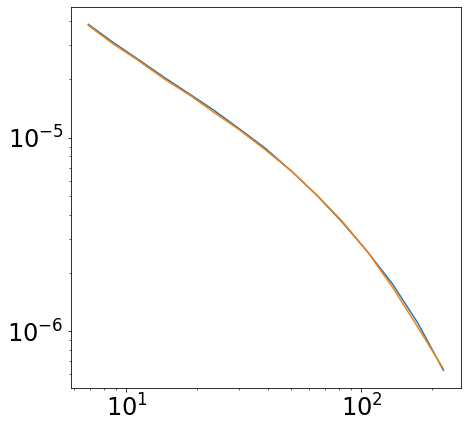

In [27]:
pl.figure()
pl.plot(r_kappaw_here,xi_kappaw_here)
pl.plot(r_kappaw_dfi,xi_kappaw_dfi)
pl.xscale('log')
pl.yscale('log')


